# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import beta, gaussian_kde, norm, gamma, multivariate_normal, binom
import seaborn as sns
from sklearn.neighbors import KernelDensity
from theano import tensor as tt

%matplotlib inline

# Background

Many of the tests we conduct on loan applications are likely to affect both i) the probability of the application leading to a loan `p(loan)`; and ii) the mean CLTV of those loans `E(CLTV|loan)`. In general we will start tests with prior beliefs over the probable values of these factors and would like to update these beliefs as we observe new test data, so that we can make CLTV-optimal decisions.

Formulating and updating our beliefs about `p(loan)` is comparatively straightforward - there are more data points to learn from (# applications > # loans), the outcome is binary and the methods to reason about and update our beliefs are well-established (e.g. using a Beta distribution to represent our prior belief over `p(loan)` and updating this as data comes in).

However reasoning about `E(CLTV|loan)` is much harder. Firstly, we will have fewer data points. Secondly, these can take a continuous and wide range of values and may include outliers. Thirdly, the choice of distribution to model the population of possible CLTVs is not obvious but will have a significant effect on the impact of observed data when updating our beliefs about `E(CLTV|loan)`.

These problems can seem so hard to tackle that in practice many tests have assumed a fixed average value for `E(CLTV|loan)` which is not updated with test data, i.e. effectively assuming that `p(loan)` is the only factor driving total CLTV. However, even if we do take on the increased complexity of using a common parametric distribution such as a normal or gamma distribution to model CLTV populations, there are also significant problems with these choices.

This notebook will cover those problems briefly before outlining an alternative approach that i) uses empirical data to build a reference distribution for CLTV; and ii) allows the distribution of a scale factor for this distribution - which represents the belief over `E(CLTV|loan)` - to be learned.


# Get reference data

In [2]:
reference_data = pd.read_csv('reference_data_for_empirical_dist.csv')
empirical_n_loans = len(reference_data)
empirical_cltvs = reference_data['cltv_total_initial']
min_cltv = empirical_cltvs.min()
max_cltv = empirical_cltvs.max()
range_cltv = max_cltv - min_cltv
empirical_cltvs.describe()

count       388.000000
mean      14693.735079
std       16333.897814
min      -13208.091740
25%        5730.786413
50%        9044.732007
75%       18818.293150
max      149725.482400
Name: cltv_total_initial, dtype: float64

# Common parametric distributions

Two common choices of distribution to model continuous random variables are the normal and gamma distributions. Scipy includes methods to learn the maximum likelihood estimate (MLE) of their parameters from observed data, and pymc3 allows probability distributions over their parameters to be learned. However, whilst it is tempting to use these out-of-the box methods, both distributions have significant issues when used to model the distribution of CLTVs:

## Normal
The normal distribution is symmetric about its mean which doesn’t reflect the reality of CLTV values, which have a long right-sided (high CLTV) tail. This means that high CLTV values observed in a test would influence results too strongly.

### Fit the distribution

In [3]:
norm_fitted_mean, norm_fitted_sd = norm.fit(empirical_cltvs)

### Graphical check of goodness of fit

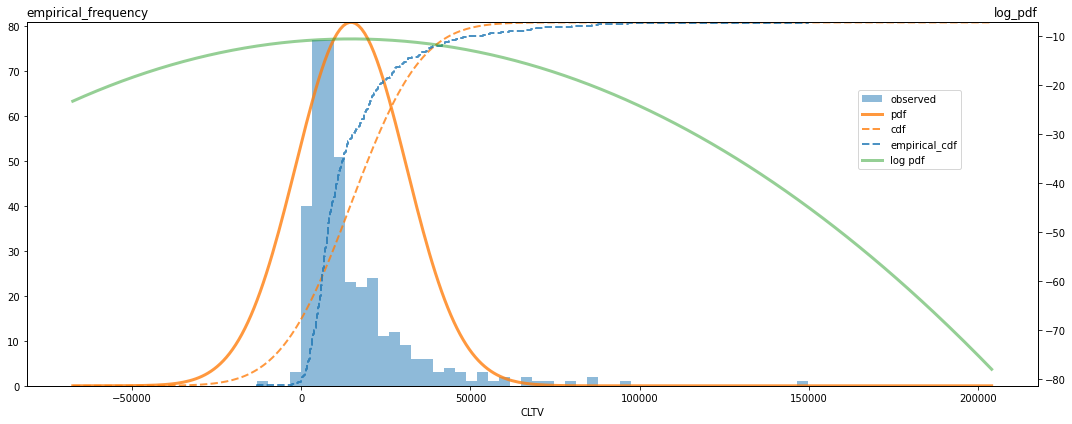

In [4]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = norm(norm_fitted_mean, norm_fitted_sd).pdf(x)
y_pdf /= max(y_pdf)
y_cdf = norm(norm_fitted_mean, norm_fitted_sd).cdf(x)
y_log = norm(norm_fitted_mean, norm_fitted_sd).logpdf(x)

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

## Gamma
By choosing a suitable shape parameter it is possible to define a gamma distribution with a similar long-right-tailed shape to the observed distribution of CLTVs. However unless the distribution is shifted, it cannot represent negative CLTVs, and it will never have support over the whole range of negative numbers. In order to learn a useful distribution, we need to decide where to locate the minimum allowed value (based on domain knowledge), or to trust scipy to learn this value. Either way, the location chosen has a strong bearing on the distribution learned.

### Fit the distribution

In [5]:
# gamma_fitted_shape, gamma_fitted_loc, gamma_fitted_scale = gamma.fit(empirical_cltvs, loc=min_cltv)
gamma_fitted_shape, gamma_fitted_loc, gamma_fitted_scale = gamma.fit(empirical_cltvs, floc=-30000)

### Graphical check of goodness of fit

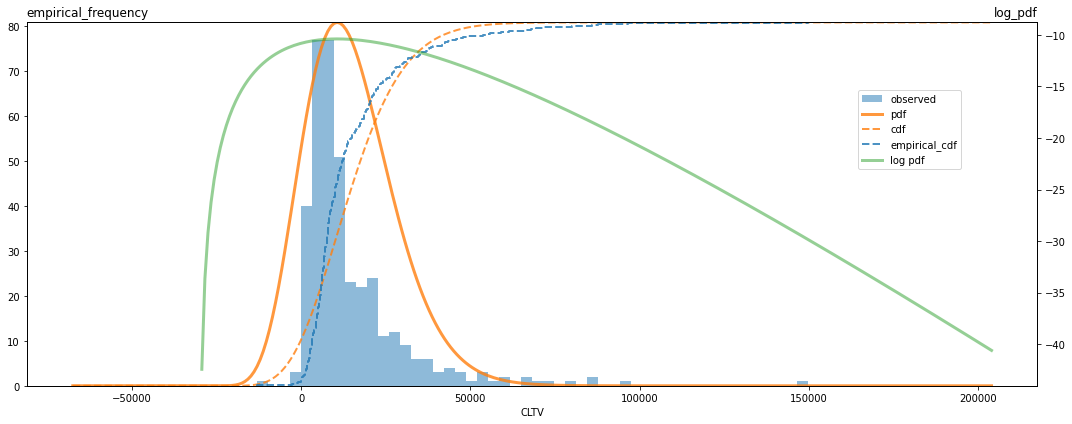

In [6]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = gamma(gamma_fitted_shape, gamma_fitted_loc, gamma_fitted_scale).pdf(x)
y_pdf /= max(y_pdf)
y_cdf = gamma(gamma_fitted_shape, gamma_fitted_loc, gamma_fitted_scale).cdf(x)
y_log = gamma(gamma_fitted_shape, gamma_fitted_loc, gamma_fitted_scale).logpdf(x)

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

## Discussion

Neither normal nor gamma distributions do a good job of fitting the data when using scipy's fit method - both are much too wide, likely caused by their need to assign some probability weight to the regions containing outliers. Gamma does a slightly better job, but requires a semi-arbitrary cutoff to be defined which will cause problems when reasoning about CLTVs out of its support range.

Both distributions also implicitly assume a single underlying generative process. This doesn’t reflect iwoca’s reality - the presence of different products and product features in our mix of loan offerings mean that our CLTV distribution is likely to be a mixture of other simpler distributions. Empirical distributions can potentially address all these problems.

# Empirically derived distributions

In this context, an empirically derived distribution is one that uses historical CLTV values to define its probability density function (pdf). These distributions will naturally match the **shape** of CLTV distribution generated by our historic product offering, including its range of support, shape features due to underlying product differences and account events such as defaults. By defining learnable **scale** and/or **location** parameter(s) that transform this distribution (allowing mean CLTV to increase or decrease), we can learn how tests have affected `E(CLTV|loan)`, under the implicit assumption that the shape of the distribution will be unchanged. Some options for these parameters are:

1. A single multiplicative scale factor that acts to stretch the pdf about CTLV = 0
2. A single translation (location) factor that shifts the pdf along the CTLV axis
3. A transformation represented by a combination of these parameters (e.g. a multiplication followed by a translation)

Arguments could be made for each of these approaches - the rest of this notebook will focus on option 1 for illustrative purposes. This approach implicitly assumes that tests will act to multiply the CLTV of all loans equally, across product and event types. This is unlikely to be true in practice, as tests are likely to affect different subsets of loans in different ways. However it should represent an improvement on normal and gamma distributions.

### Aside - possible Simpson’s paradox issue
Another dynamic that scale and/or location factors cannot model well is changes in the **mix** of underlying loan types generated by a test branch. Likelihood maximisation learning could potentially give rise to a reversal of the usual Simpson’s paradox effect, whereby e.g. for a bimodal empirical pdf, true CLTV goes up due to a greater mix of the high value loans, but the scale factor learned could be negative if both high and low value modal locations have decreased in value. This suggests an alternative approach that could use a mixture of empirical distributions with the mixture proportion itself a learned parameter - this approach is beyond the scope of this doc.

## Building a “reference” empirical distribution - practical approach

We want to build a continuous pdf with support over all possible values of loan, from a sample of observed CLTV values. The most obvious way to do this is by using kernel density estimation (KDE). This approach assumes that probability density is located around the values which we have actually observed, with the shape and (band)width of the kernel representing how probability density is distributed about these points - this kernel effectively replaces the discrete probability mass at each data point and the addition of these kernels yields the overall pdf.

I considered two possible kernels to build the empirical pdf - a gaussian and an exponential. Scipy has the simplest interface to do this - scipy.stats.gaussian_kde (which is also used by seaborn to build its kdeplots), but only supports gaussian kernels as implied by its name. A more flexible interface is provided by sklearn.neighbors.KernelDensity. Scipy provides automatic but overridable bandwidth estimation, whereas sklearn requires bandwidth to be provided explicitly.

The main practical difference between the kernel shapes is in how they extrapolate probability density estimates outside the empirical support region of the data: the log of the probability density tails off quadratically outside of the support region for the gaussian kernel, whereas it tails off linearly for the exponential kernel. This means that a KDE built with an exponential kernel is much more tolerant of (assigns higher probability to) data points outside of its empirical range than the gaussian KDE. Given i) what we know about CLTV outliers (they happen); ii) the fact that empirical CLTV distribution more closely resembles an exponential than a normal; and iii) our objective of learning scale factors by maximising usage of observed data (as opposed to drawing conclusions that are dominated by a few points), an exponential kernel fits the bill much better here.

A low bandwidth will place narrower kernels on each point, leading to a more “bumpy” pdf with high-frequency variation. This may either reflect genuine high frequency variation in the underlying probability or more often just be noise due to sparse data. Probability will fall sharply outside the region of empirical support. A high bandwidth will yield a smoother and wider pdf, possibly masking genuine high-frequency features and placing too much probability weight outside the region of empirical support. The bandwidth for the exponential kernel I used was chosen by inspection to be a compromise between these two.


### Fit the distribution

In [7]:
# exponential kernel chosen as most appropriate for extrapolation
# bandwidth selected by inspection
empirical_cltv_kde = KernelDensity(kernel='exponential', bandwidth=4500.)
empirical_cltv_kde.fit(empirical_cltvs.values.reshape(-1, 1));

### Graphical check of goodness of fit

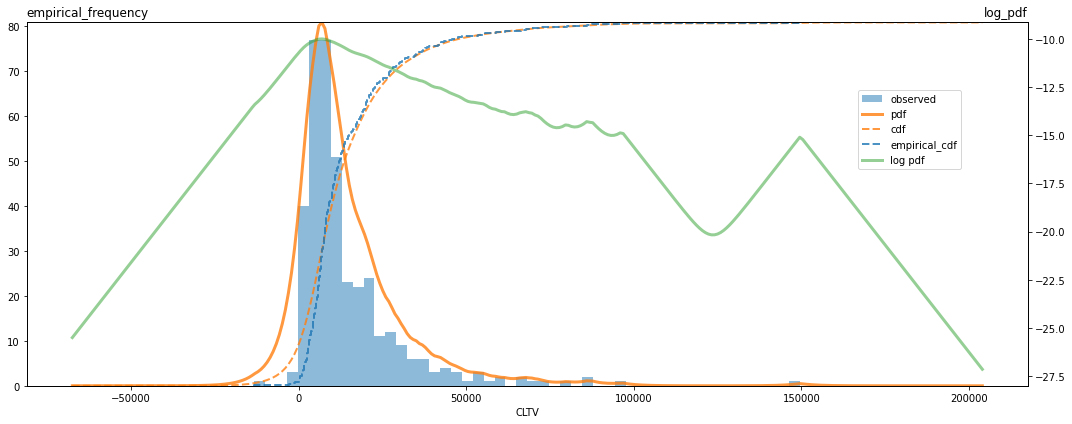

In [8]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(empirical_cltv_kde.score_samples(x.reshape(-1, 1)))
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = empirical_cltv_kde.score_samples(x.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

## Discussion

Looking at the CDF lines, this distribution seems to fit the empirical data much more closely than the normal or gamma distributions did. From the log_pdf values at the extremes it can also be seen that it assigns higher probability to values outside the range of the empirical data (which is also desirable as this means outliers are less likely to dominate learning). However the log_pdf line also reveals some weirdness in the region of sparse data towards the right of the observed data (the top ~15 highest CLTV points), where probability jumps up and down as opposed to decreasing monotonically. This is due to the fixed bandwidth of the KDE being much smaller than the distance between datapoints in this region. Unless we believe there is good reason for probability density to be higher at these points, manual adjustment of this region to ensure monotonicity could probably improve the utility of the distribution (see appndix for an exploration of this).

## Transforming the reference distribution using a scale factor
Now we have a reference distribution, we would like to be able to scale it to generate new distributions with the same shape but different means, and to calculate probability densities from these scaled distributions.

For a simple multiplicative factor m, the formula that will give us the scaled probability density at point x is: `pdf_scaled(x) = pdf_ref(x/m) / m`. The formula for logpdf is `log_pdf_scaled(x) = log_pdf_ref(x/m) - log(m)`.

## Learning a scale factor for observed data
Our goal is to understand how tests affect `E(CLTV|loan)`. Now that we have a reference CLTV distribution and a means of scaling it, we can learn the posterior distribution of this scale factor - given some observed CLTV data and a prior distribution of the scale factor - by computing the likelihood of the observed data for given scale factors. This will allow us to estimate `E(CLTV|loan)`, as well as the expected loss of making a choice to favour one branch over another, which in turn can inform a decision to continue experimenting or not.

Practically, pymc3 provides a nice framework to set up a prior over the scale factor, parameterise the problem and learn and plot the posterior distribution. Some manipulations are required to approximate the output of the sklearn.neighbors.KernelDensity object using a pymc3 distribution and to allow this distribution to accept a learnable scale factor, but these are relatively simple:

### Approximate KDE using pymc.Interpolated to allow learning of the scale factor

In [9]:
x_points = np.linspace(min_cltv - range_cltv, max_cltv + range_cltv, 10000)
pdf_points = np.exp(empirical_cltv_kde.score_samples(x_points.reshape(-1, 1)))
empirical_cltv_dist = pm.Interpolated.dist(x_points, pdf_points)

## Sense checking the scale factor learned for reference data
Now that we have a reference distribution and the ability to learn a probability distribution over the scale factor for observed data, it makes sense to check the scale factor that is learned if we feed our learning algorithm the reference data itself (i.e. the data that was used to build the reference distribution). Intuitively we expect this factor to be distributed around 1.0 (i.e. its log should be around 0.0):

### Estimate the log scale factor for the reference data (should be ≈ 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


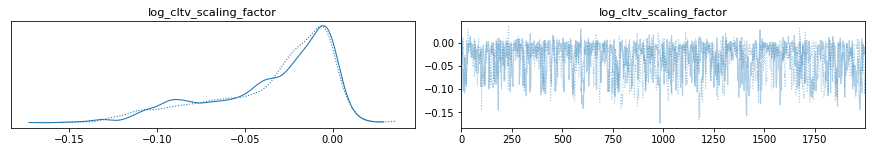

In [16]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model:
    # uninformative prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -1.0, 1.0)

    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor

    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)

    # plot
    log_cltv_scale_prior_trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace)

## Discussion

Interestingly, the scale factor learned for the reference data itself has a mean of ~0.97, i.e. slightly below 1.0 and a distribution skewed towards lower values. I think that this is probably due to the inherent smoothing and spreading of probability density induced when building KDEs: for any bandwidth > 0, the width of the distribution (vs the empirical range) is increased, and modal peaks are blurred in both directions. Squashing the distribution back closer to its empirical (discrete) shape with a scale factor < 1 can give a higher likelihood to the observed data.

# Appendix 1: smoothing pdf noise at high CLTV

### Use pymc.Interpolated approximation to interpolate pdf in the noisy region

In [18]:
# defining the noisy region as CLTV > 50000,
# we can evaluate the pdf just at the observed data points here and interpolate between them
x_points2 = np.concatenate([
    np.linspace(min_cltv - range_cltv, 50000, 100),
    np.array(empirical_cltvs[empirical_cltvs > 50000].sort_values())[:-1],
    np.linspace(max_cltv, max_cltv + range_cltv, 100),
])

pdf_points2 = np.exp(empirical_cltv_kde.score_samples(x_points2.reshape(-1, 1)))
empirical_cltv_dist2 = pm.Interpolated.dist(x_points2, pdf_points2)

### Visualise impact of this interpolation

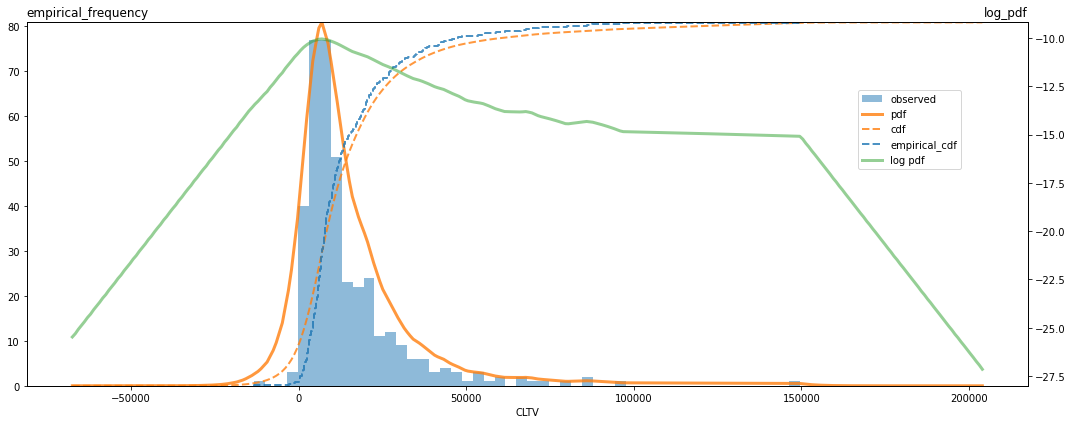

In [19]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(empirical_cltv_dist2.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = empirical_cltv_dist2.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

This approach has clearly removed the noise from the high CLTV region. However it has also increased the total probability mass in this region which can be seen in the divergence of the CDF lines.

### Estimate the log scale factor for the reference data (should be ≈ 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


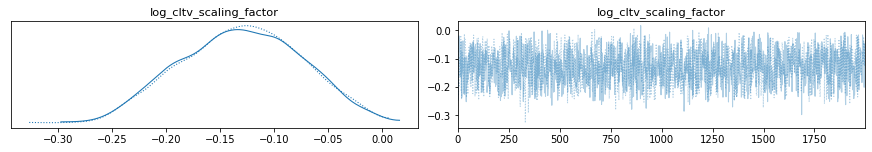

In [20]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model2:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -1.0, 1.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist2.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)
    
    # plot
    log_cltv_scale_prior_trace2 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace2)

## Discussion

With the modified distribution, pymc3 is learning a scale factor of around 0.87 - much lower than 1.0. This is because the additional probability mass assigned to the high CLTV region (via smoothing) means that the high CLTV observed datapoints are less strongly influencing the scale factor. Further adjustment to the distribution is probably required to counteract this effect (e.g. by smoothing the shape of the distribution in this region but keeping overall probability mass the same).

## Trying a differential approach by data density

Let's model the data as having 3 regions:
 - sparse low CLTV (<£1500: 17 loans)
 - dense mid CLTV (£1500-£50,000: 356 loans)
 - sparse high CLTV (>£50,000: 15 loans)
 
Let the data determine density in the mid region. In the other regions, fit an exponential such that the density is continuous and the total probability mass in the region is correct.

In [21]:
LOW_BOUND = 1500
HIGH_BOUND = 50000

In [22]:
prob_mass_low = (empirical_cltvs < LOW_BOUND).mean()
prob_mass_high = (empirical_cltvs > HIGH_BOUND).mean()
density_low_bound = np.exp(empirical_cltv_kde.score(np.array(LOW_BOUND).reshape(-1, 1)))
density_high_bound = np.exp(empirical_cltv_kde.score(np.array(HIGH_BOUND).reshape(-1, 1)))

In [23]:
def exponential_density(x, bound, density_at_bound, prob_mass, positive_tail=True):
    sign = 1 if positive_tail else -1
    return density_at_bound * np.exp(-(x - bound) * sign * (density_at_bound / prob_mass))

In [96]:
# defining the noisy region as CLTV > 50000,
# we can evaluate the pdf just at the observed data points here and interpolate between them
low_x_points = np.linspace(min_cltv - range_cltv, LOW_BOUND, 1000, endpoint=False)
mid_x_points = np.linspace(LOW_BOUND, HIGH_BOUND, 1000, endpoint=False)
high_x_points = np.linspace(HIGH_BOUND, max_cltv + range_cltv, 1000, endpoint=True)

low_pdf_points = exponential_density(low_x_points, LOW_BOUND, density_low_bound, prob_mass_low, False)
mid_pdf_points = np.exp(empirical_cltv_kde.score_samples(mid_x_points.reshape(-1, 1)))
high_pdf_points = exponential_density(high_x_points, HIGH_BOUND, density_high_bound, prob_mass_high, True)

In [97]:
x_points3 = np.concatenate([low_x_points, mid_x_points, high_x_points])
pdf_points3 = np.concatenate([low_pdf_points, mid_pdf_points, high_pdf_points])

empirical_cltv_dist3 = pm.Interpolated.dist(x_points3, pdf_points3)

### Visualise impact of this interpolation

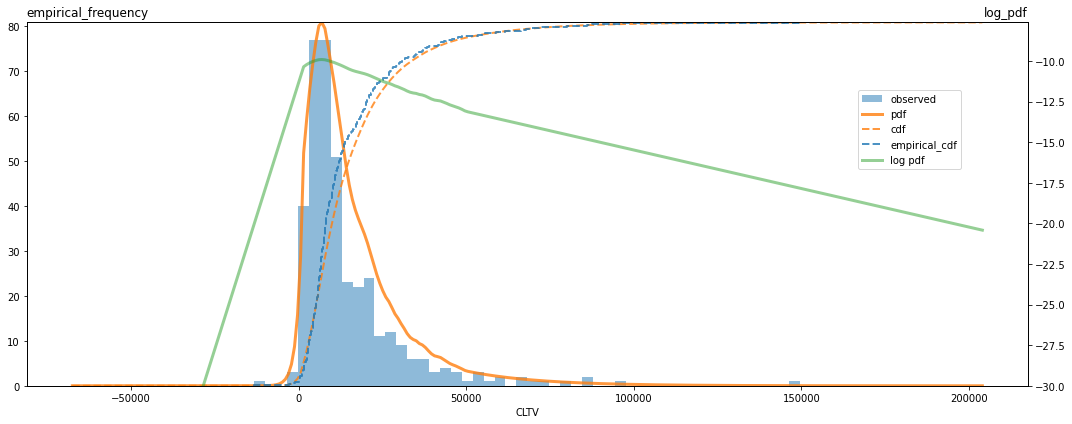

In [98]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(empirical_cltv_dist3.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = empirical_cltv_dist3.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax3.set_ylim(bottom = -30)
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

The discrepancy between the CDFs is now dominated by the middle KDE region. Now that we don't need such a wide bandwidth to model data in the extreme regions, we should be able to improve fit by reducing bandwidth.

## Tighten kernels

In [99]:
# exponential kernel chosen as most appropriate for extrapolation
# bandwidth selected by inspection
empirical_cltv_kde2 = KernelDensity(kernel='exponential', bandwidth=2500.)
empirical_cltv_kde2.fit(empirical_cltvs.values.reshape(-1, 1));

In [100]:
mid_pdf_points2 = np.exp(empirical_cltv_kde2.score_samples(mid_x_points.reshape(-1, 1)))

In [101]:
x_points4 = np.concatenate([low_x_points, mid_x_points, high_x_points])
pdf_points4 = np.concatenate([low_pdf_points, mid_pdf_points2, high_pdf_points])

empirical_cltv_dist4 = pm.Interpolated.dist(x_points4, pdf_points4)

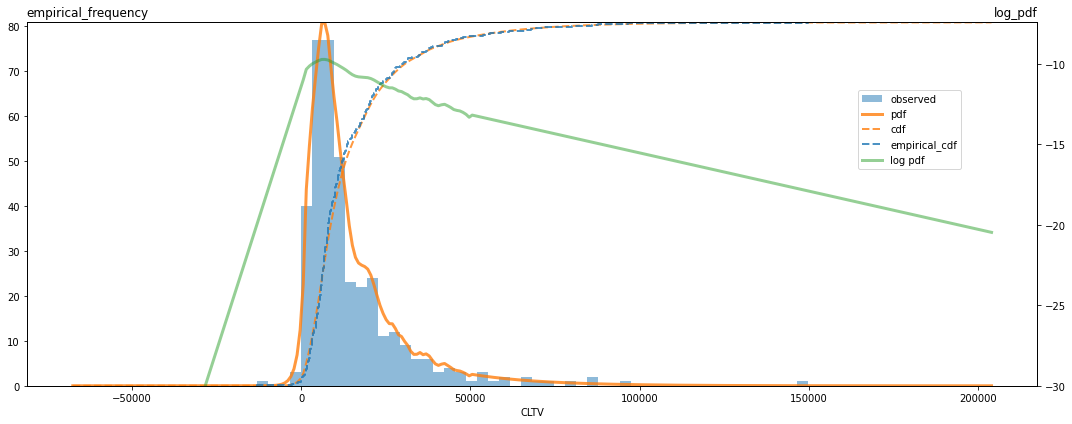

In [102]:
x = np.linspace(min_cltv - range_cltv/3, max_cltv + range_cltv/3, 300)
y_pdf = np.exp(empirical_cltv_dist4.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = empirical_cltv_dist4.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax3.set_ylim(bottom = -30)
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

This appears to be a good compromise between fitting real patterns in the data and avoiding high-frequency noise.

# Appendix 2: Testing the approach

In [112]:
empirical_cltv_dist4_mean = empirical_cltv_dist4.random(size=10000000).mean()
empirical_cltv_dist4_mean

15409.838851293598

### Check the distribution returns a scale factor of ≈1.0 when fed its training data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.6692467973965603, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


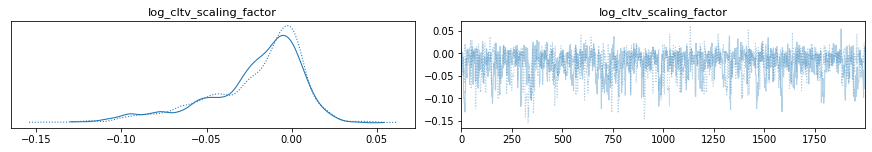

In [103]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -1.0, 1.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)
    
    # plot
    log_cltv_scale_prior_trace4 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace4)

This posterior has a mean of 0.98

### Check the distribution returns a scale factor ≈X when fed its training data * X

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


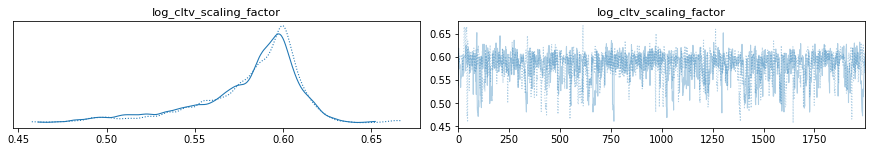

In [104]:
obs_cltv = np.array(empirical_cltvs.sort_values()) * np.exp(0.6)

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)
    
    # plot
    log_cltv_scale_prior_trace4 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace4)

In [105]:
log_cltv_scale_prior_trace4.posterior.log_cltv_scaling_factor.values.mean()

0.5807395199839904

This posterior has a mean of exp(0.58)

### Other datasets
A large sample of:
 - points generated from the distribution itself
 - points generated from the distribution multiplied by a scale factor X
 - points generated from a shifted version of the distribution (negative and positive shifts)
 - points generated from a mixture of two scaled distributions

In [147]:
dataset_1 = empirical_cltv_dist4.random(size=1000)
dataset_2 = empirical_cltv_dist4.random(size=1000) * np.exp(-0.2)
dataset_3 = empirical_cltv_dist4.random(size=1000) - (empirical_cltv_dist4_mean * 0.3)
dataset_4 = empirical_cltv_dist4.random(size=1000) + (empirical_cltv_dist4_mean * 0.7)
dataset_5 = np.concatenate([empirical_cltv_dist4.random(size=500) * 0.5,
                            empirical_cltv_dist4.random(size=500) * 1.5])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


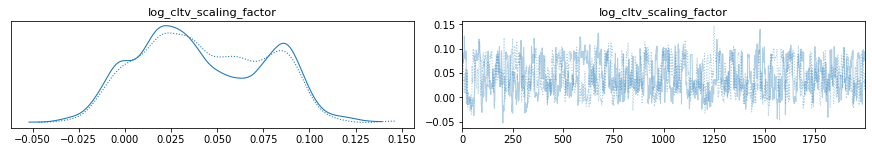

In [148]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=dataset_1)
    
    # plot
    log_cltv_scale_dataset_1 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_dataset_1)

In [149]:
posterior_mean = np.exp(log_cltv_scale_dataset_1.posterior.log_cltv_scaling_factor.values).mean()
print(f'True mean ratio: {dataset_1.mean()/empirical_cltv_dist4_mean:.3f}')
print(f'Mean of scaling factor posterior distribution: {posterior_mean:.3f}')

True mean ratio: 1.057
Mean of scaling factor posterior distribution: 1.044


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


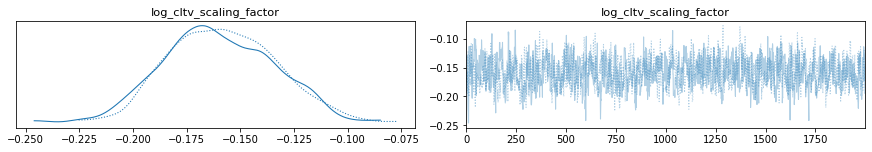

In [150]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=dataset_2)
    
    # plot
    log_cltv_scale_dataset_2 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_dataset_2)

In [151]:
posterior_mean = np.exp(log_cltv_scale_dataset_2.posterior.log_cltv_scaling_factor.values).mean()
print(f'True mean ratio: {dataset_2.mean()/empirical_cltv_dist4_mean:.3f}')
print(f'Mean of scaling factor posterior distribution: {posterior_mean:.3f}')

True mean ratio: 0.841
Mean of scaling factor posterior distribution: 0.853


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


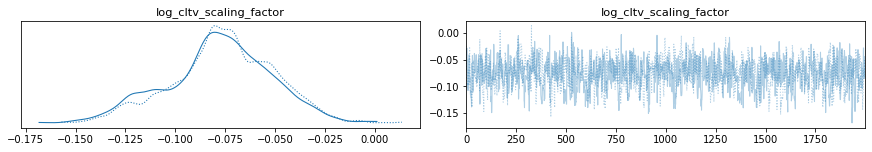

In [152]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=dataset_3)
    
    # plot
    log_cltv_scale_dataset_3 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_dataset_3)

In [153]:
posterior_mean = np.exp(log_cltv_scale_dataset_3.posterior.log_cltv_scaling_factor.values).mean()
print(f'True mean ratio: {dataset_3.mean()/empirical_cltv_dist4_mean:.3f}')
print(f'Mean of scaling factor posterior distribution: {posterior_mean:.3f}')

True mean ratio: 0.739
Mean of scaling factor posterior distribution: 0.926


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


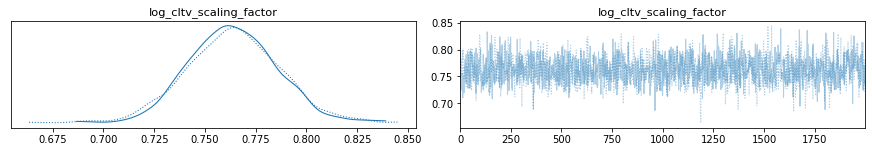

In [154]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=dataset_4)
    
    # plot
    log_cltv_scale_dataset_4 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_dataset_4)

In [155]:
posterior_mean = np.exp(log_cltv_scale_dataset_4.posterior.log_cltv_scaling_factor.values).mean()
print(f'True mean ratio: {dataset_4.mean()/empirical_cltv_dist4_mean:.3f}')
print(f'Mean of scaling factor posterior distribution: {posterior_mean:.3f}')

True mean ratio: 1.658
Mean of scaling factor posterior distribution: 2.147


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 1097 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1017 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


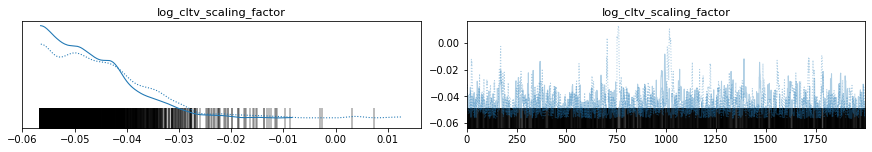

In [156]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model4:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -2.0, 2.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist4.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=dataset_5)
    
    # plot
    log_cltv_scale_dataset_5 = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_dataset_5)

In [157]:
posterior_mean = np.exp(log_cltv_scale_dataset_5.posterior.log_cltv_scaling_factor.values).mean()
print(f'True mean ratio: {dataset_5.mean()/empirical_cltv_dist4_mean:.3f}')
print(f'Mean of scaling factor posterior distribution: {posterior_mean:.3f}')

True mean ratio: 1.018
Mean of scaling factor posterior distribution: 0.956


# Appendix 3: Thoughts on coming up with a prior over the scale factor
A common test setup is to have control and test branches where we are looking to estimate the uplift of some metric on the test branch relative to the control branch. Usually we will collect the prior over this uplift from the business. However we also need a prior over the baseline level of the metric in the control branch in order to interpret the observed data from both branches in true A/B fashion.

If the metric in question is `E(CLTV|loan)`, and we expect that the control branch will behave similarly to the recent past, we could use recent loan values to derive a prior over the control scale factor as follows: update an initial non-informative prior (e.g. uniform in log space between sufficiently wide bounds) to yield the posterior distribution over scale factor for these recent observed data. Use this as the control branch prior over the scale factor for our test. The strength of this prior could be altered by flexing the number of recent loans used (e.g. by (down)sampling at regular intervals in the cdf of recent loans) - analogous to dividing the parameters of a beta prior to adjust for relative confidence - or applying a stretching factor to the resultant prior e.g. by a factor - analogous to the √n that determines sample standard deviation for a normal distribution.
